## **Air quality - GIOS data analysis**
### Advanced Databases
### Automatic Control and Robotic, Cyber-physical Systems
#### **Daniel Jurkowski (407200) & Adam Pękala (405380) & Rafał Maciasz (000000) & Jakub Sacha (000000)**

1. Import required packages 

In [163]:
import psycopg2
import requests
import pandas as pd
import matplotlib.pyplot as plt

2. Connect to database

In [164]:
db_name = 'gios_data'
db_user = 'postgres'
db_password = 'kochamadb'
db_host = 'localhost'
db_port = '5000'

conn = psycopg2.connect(
    dbname=db_name,
    user=db_user,
    password=db_password,
    host=db_host,
    port=db_port
)

GET /pjp-api/rest/station/findAll curl - List of all sensors

In [165]:
# Get all sensors id's
def get_all_ids():
    response = requests.get("https://api.gios.gov.pl/pjp-api/rest/station/findAll")
    data = response.json()

    ids = [station['id'] for station in data]
    return ids

GET /pjp-api/v1/rest/data/getData/{idSensor} curl - Network service making available measurement data based on the given measurement site ID, from the last full hour up to the third day back. The measurement results are made available in local time, i.e. in summer in CEST time (UTC+ 02:00, Central European Summer Time), in winter in CET time (UTC+ 01:00, Central European Winter Time).

In [166]:
cur = conn.cursor()

cur.execute('''
CREATE TABLE IF NOT EXISTS measurements (
    station_id VARCHAR(255),
    date_time TIMESTAMP,
    value DECIMAL
);
''')
conn.commit()

def insert_data_to_db(conn, data):
    cur = conn.cursor()
    if data['Lista danych pomiarowych']:
        for measurement in data['Lista danych pomiarowych']:
            cur.execute('''
                INSERT INTO measurements (station_id, date_time, value)
                VALUES (%s, %s, %s);
            ''', (
                measurement['Kod stanowiska'],
                measurement['Data'],
                measurement['Wartość']
            ))
        conn.commit()

def fetch_data_from_api(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        return response.json()
    else:
        return None
    
all_ids = get_all_ids()

for id in all_ids:
    api_url = f'https://api.gios.gov.pl/pjp-api/v1/rest/data/getData/{id}'

    data = fetch_data_from_api(api_url)

    if data:
        insert_data_to_db(conn, data)
    

           station_id           date_time    value
0  DsCzerStraza-O3-1g 2024-06-05 00:00:00     None
1  DsCzerStraza-O3-1g 2024-06-04 23:00:00  115.943
2  DsCzerStraza-O3-1g 2024-06-04 22:00:00   93.835
3  DsCzerStraza-O3-1g 2024-06-04 21:00:00  59.3694
4  DsCzerStraza-O3-1g 2024-06-04 20:00:00  97.1772


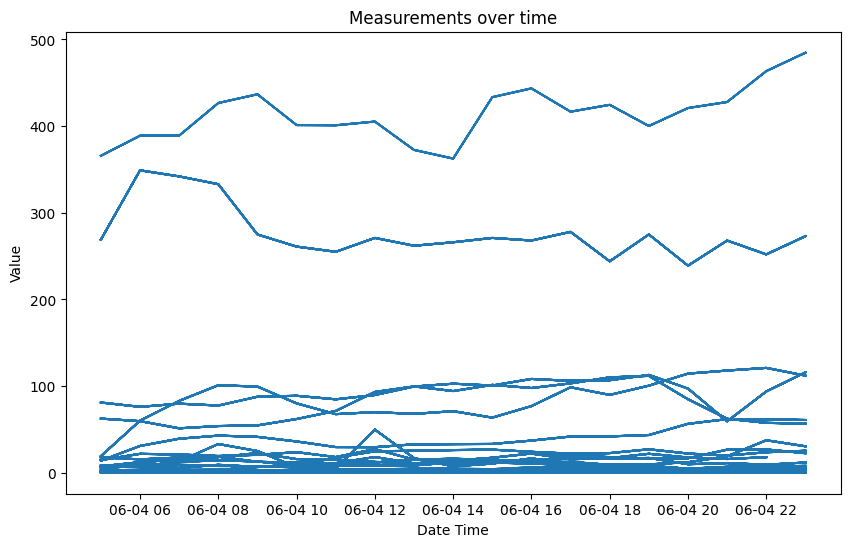

In [167]:
#### TEST ####
cur.execute("SELECT * FROM measurements;")

rows = cur.fetchall()

cur.close()
conn.close()

df = pd.DataFrame(rows, columns=['station_id', 'date_time', 'value'])

print(df.head())

plt.figure(figsize=(10,6))
plt.plot(df['date_time'], df['value'])
plt.xlabel('Date Time')
plt.ylabel('Value')
plt.title('Measurements over time')
plt.show()